### Imports

In [46]:
%load_ext google.cloud.bigquery
%matplotlib inline
from google.cloud import bigquery
client = bigquery.Client()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cluster
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import random
from sklearn.cluster import KMeans
import matplotlib.cm as cm
%run silhouette_plotter.py
%run parse.py
from mpl_toolkits.mplot3d import Axes3D

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


### Load data from Bigquery

In [47]:
table = 'eth-tokens.test.clean_avg_1MM_with_balances_tokens'
label_table = 'eth-tokens.alldata.etherscan_labelcloud'

In [48]:
sql = '''
SELECT *  FROM `{}`
'''.format(table)

df = client.query(sql).to_dataframe()

In [49]:
#remove address (string) from analysis
data = df.iloc[:,1:]

In [8]:
#number of PCA features is full reconstruction, for now
num_features = data.shape[1]
num_clusters = 4
num_features = 15

In [50]:
pwr = PowerTransformer(standardize=False)
scale = StandardScaler()
pca =PCA(n_components=num_features)
cl = KMeans(num_clusters)

#build pipeline
pipe = Pipeline([('power', pwr ),
                 ('scale', scale ),
                 ('PCA', pca)])

results = pipe.fit_transform(data)




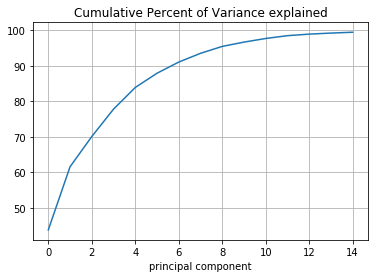

In [51]:
#percent of variance explained by each component

plt.plot(np.arange(pca.n_components_) ,np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid(b=True)
plt.xlabel('principal component')
plt.title('Cumulative Percent of Variance explained')
plt.show()

### Choose number of clusters with Calinski-Harabaz, Elbow Plot

In [ ]:
# #scoring metric?
# from sklearn.metrics import calinski_harabaz_score as ch_score
# clusters = [3,5,8,10,15,20,30,40,60,80]
# scores = []
# inertias = []
# for c in clusters:
#     cl_n = KMeans(c).fit(results)
#     score = ch_score(results, cl_n.labels_)
#     scores.append(score)
#     inertias.append(cl_n.inertia_)


# plt.plot(clusters, scores)
# plt.title('Calinski Harabaz Scores')

In [ ]:
# #elbow plot
# plt.plot(clusters,inertias)
# plt.title('Elbow plot')
# plt.ylabel('within cluster sum of squares')

## Optimal clusters

In [11]:
#optimal number of clusters is around 40
cl = KMeans(15)
cl.fit(results)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [ ]:
# %run silhouette_plotter.py
# X=results
# range_n_clusters = [20]
# if len(newresults) <20000:
#     silhouette_plotter(X, range_n_clusters)

In [12]:
#subset results for tsne
#address mask needed for later superposition
max_size = len(results)
subset_results = []
lbls = []
address_mask = np.array([False for addr in df['address']]) 
for c in np.unique(cl.labels_):
    mask = (cl.labels_==c)
    c_size = np.sum(mask)
    if c_size < max_size:
        lbls.extend(list(cl.labels_[cl.labels_==c]))
        subset_results.append(results[mask])
        address_mask |= mask
lbls=np.array(lbls)
subset_results=np.vstack(subset_results)

In [13]:
# #not using subset
# subset_results = results
# lbls = cl.labels_

In [14]:
import time
from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(subset_results)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 35917 samples in 0.024s...
[t-SNE] Computed neighbors for 35917 samples in 12.886s...
[t-SNE] Computed conditional probabilities for sample 1000 / 35917
[t-SNE] Computed conditional probabilities for sample 2000 / 35917
[t-SNE] Computed conditional probabilities for sample 3000 / 35917
[t-SNE] Computed conditional probabilities for sample 4000 / 35917
[t-SNE] Computed conditional probabilities for sample 5000 / 35917
[t-SNE] Computed conditional probabilities for sample 6000 / 35917
[t-SNE] Computed conditional probabilities for sample 7000 / 35917
[t-SNE] Computed conditional probabilities for sample 8000 / 35917
[t-SNE] Computed conditional probabilities for sample 9000 / 35917
[t-SNE] Computed conditional probabilities for sample 10000 / 35917
[t-SNE] Computed conditional probabilities for sample 11000 / 35917
[t-SNE] Computed conditional probabilities for sample 12000 / 35917
[t-SNE] Computed conditional probabilities for s

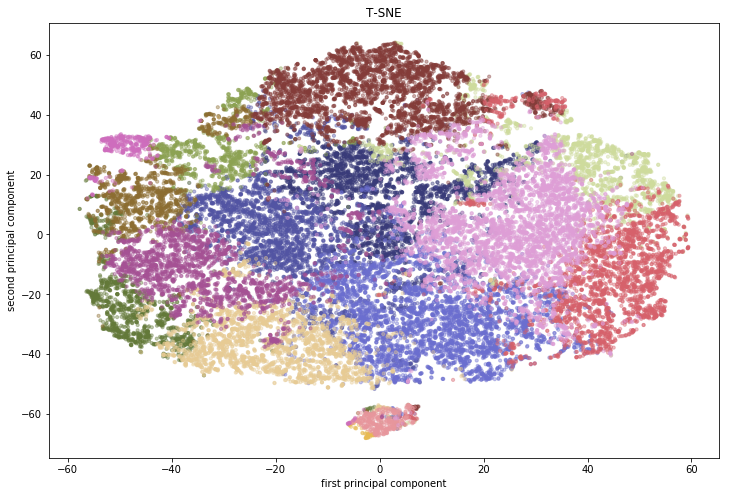

In [15]:
#color coded by cluster
plt.figure(figsize=(12,8))

plt.scatter(tsne_results[:,0], tsne_results[:,1], s=10,c=lbls,cmap='tab20b', alpha=.4)


# leg = plt.legend()




# for lh in leg.legendHandles: 
#     lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

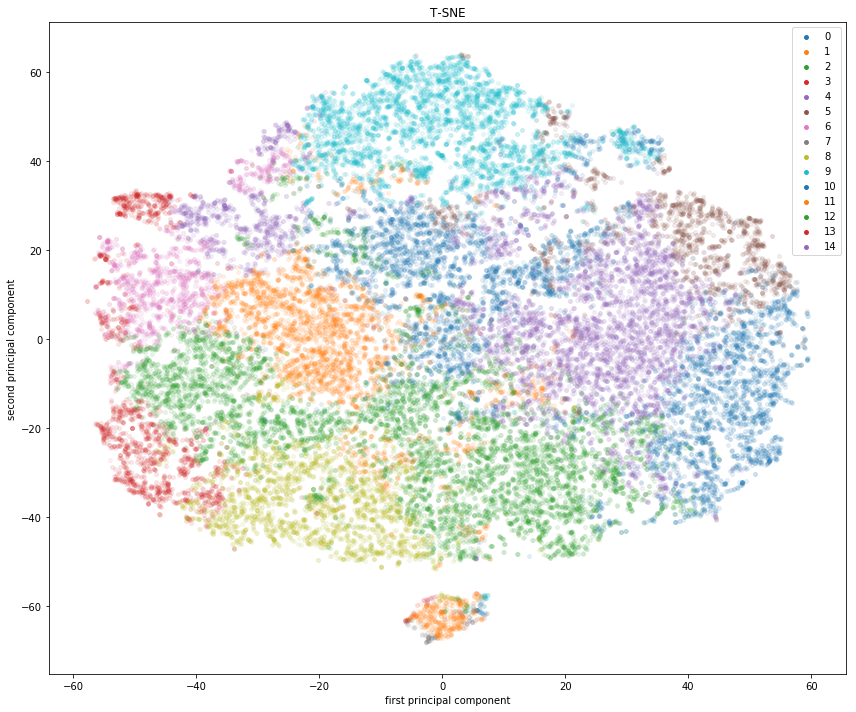

In [16]:

plt.figure(figsize=(12,10))
for c in np.unique(lbls):
    mask = lbls==c
    if np.sum(mask) <0:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], s=15,alpha=.1,label=lbl)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.tight_layout()

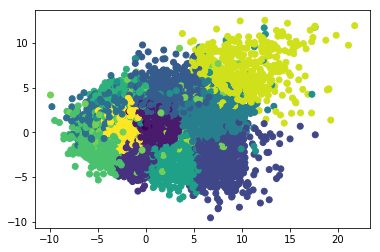

In [17]:
plt.scatter(results[:,0],results[:,1],c=cl.labels_)
# plt.xlim(-10,100)
# plt.ylim(-15,10)

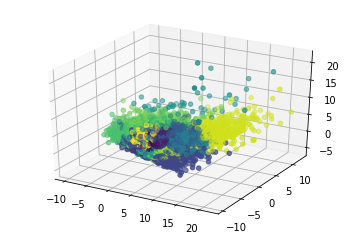

In [18]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)

# ax.set_xlim3d(-10,10)
# ax.set_ylim3d(-15,10)

## Label centroids with cluster

In [19]:
c = cl.cluster_centers_
#transform back to real numbers
centroids = pwr.inverse_transform(scale.inverse_transform(pca.inverse_transform(c)))
df_summary = pd.DataFrame(centroids, columns = data.columns)

In [20]:
#put cluster sizes into summary dataframe
cluster_sizes = pd.Series(cl.labels_).value_counts()
df_summary['cluster_size'] = cluster_sizes


In [21]:
df_summary.sort_values('cluster_size', ascending=False, axis=0, inplace=True)
df_summary

,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,total_usd_recd,avg_usd_recd,...,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns,num_tokens_used,eth_balance,cluster_size
14,9.299800,11.058253,40.044448,4.837895,2.109821e+04,2393.154356,108.087428,11.059765,4.049008e+04,3830.322162,...,2.778819e+03,0.001077,0.001716,1.811075e+06,2.741288e+06,1.201536e+06,1.698839e+06,13.621292,62.450101,5012
2,7.343155,8.990527,162.512474,23.574647,7.211729e+04,10240.914900,353.480495,41.152224,8.661755e+04,10153.577021,...,5.059733e+03,0.003907,0.008174,2.751879e+06,4.216919e+06,3.647360e+06,4.915541e+06,13.957633,134.268185,4731
9,10.631797,234.415196,54.529855,5.727303,2.522280e+04,2448.711048,158.933846,0.568170,5.623043e+04,231.660226,...,3.972793e+03,0.005678,0.008083,1.329715e+05,1.290260e+05,1.718172e+06,2.229662e+06,10.482509,71.299506,3999
1,28.000832,31.979431,410.623026,16.468497,2.026418e+05,7628.268725,570.701197,20.050398,2.224070e+05,7435.089128,...,1.385045e+04,0.002005,0.003193,7.964449e+05,1.564468e+06,7.575191e+05,1.552551e+06,23.110561,110.610306,3531
0,7.366043,9.218590,73.244790,11.544594,3.594744e+04,5312.488006,181.367269,22.220513,8.150169e+04,9428.330499,...,9.457148e+03,0.000492,0.000540,4.721800e+05,6.684154e+05,7.315750e+05,9.470530e+05,5.398881,90.655249,3380
10,5.696847,10.158144,19.652076,4.018323,5.593992e+03,1043.065759,99.404456,11.567326,1.594623e+04,1636.459681,...,8.536237e+02,0.012050,0.025374,2.319851e+06,3.599178e+06,5.534055e+06,7.061726e+06,13.423640,70.770902,3235
8,10.869846,12.181659,1289.737277,115.300764,4.418313e+05,41800.007442,2432.509251,190.145197,3.535409e+05,31099.431639,...,1.783769e+04,0.008464,0.021732,1.864933e+06,3.303063e+06,2.711875e+06,4.219860e+06,21.165266,623.959842,2715
12,11.033576,12.373775,853.557556,79.392308,3.859842e+05,36668.950087,1251.365010,100.496120,5.920647e+05,49533.636397,...,6.992373e+04,0.001357,0.003153,6.435762e+05,1.039898e+06,8.132141e+05,1.184864e+06,6.162607,219.144476,2680
5,5.203901,10.570117,3.389800,0.667093,5.547994e+02,117.409883,96.457332,10.775190,3.265895e+04,3290.737105,...,2.835199e+03,0.006554,0.014573,7.496532e+05,1.064489e+06,6.825094e+05,7.523837e+05,8.843972,89.326562,1851
6,79.900132,212.726812,6182.911201,78.469850,2.734904e+06,36119.158619,6645.273257,37.418947,3.203370e+06,15819.549789,...,2.476276e+05,0.003502,0.009384,1.512291e+05,3.920706e+05,3.464865e+05,7.220723e+05,24.135070,214.385292,1416


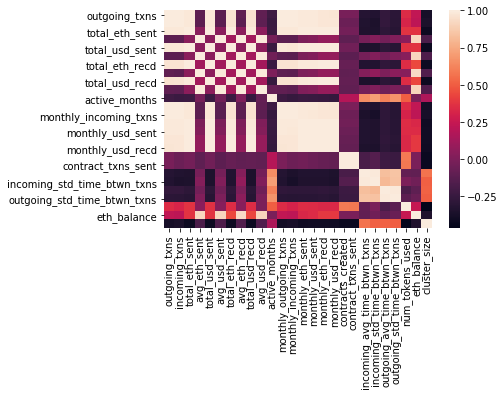

In [22]:
import seaborn as sns
sns.heatmap(df_summary.corr())

In [23]:
arr = df_summary.values

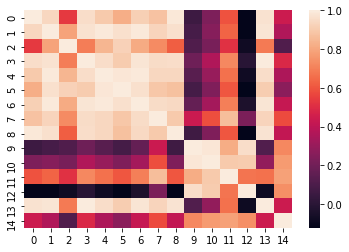

In [24]:
sns.heatmap(np.corrcoef(arr, rowvar=True))

## Review Etherscan Labels

In [25]:
sql = '''
SELECT es.label,es.category, a.*  FROM `{}` a
INNER JOIN `{}` es
ON a.address = es.address
WHERE es.label IS NOT NULL

'''.format(table, label_table)

dflabel = client.query(sql).to_dataframe()

In [26]:
lbls = []
for i, row in dflabel.iterrows():
    lbls.append(list(df['address'].values).index(row['address']))

In [27]:
dflabel['cluster'] = [cl.labels_[i] for i in lbls]

In [28]:
# for clust in range(cl.n_clusters):
#     print('cluster {}'.format(clust))
#     print('labelled points: {}'.format(np.sum([dflabel['cluster']==clust])))
#     print('total points: {}'.format(np.sum(cl.labels_==clust)))
#     print(dflabel[dflabel['cluster']==clust][['label','category']])
#     print('\n\n\n')

centralization of ownership

In [29]:
total_eth = {}
total_addresses = {}

for clust in range(cl.n_clusters):
    mask = cl.labels_==clust
    eth = np.sum(df[mask]['eth_balance'])
    size = np.sum(cl.labels_==clust)
    total_eth[clust] = eth
    total_addresses[clust] = size

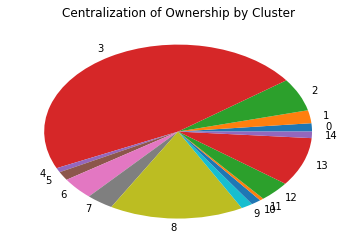

In [30]:
plt.pie(total_eth.values(), labels=total_eth.keys())
plt.title('Centralization of Ownership by Cluster')
plt.show()

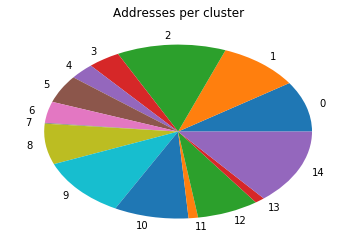

In [31]:
plt.pie(total_addresses.values(), labels=total_addresses.keys())
plt.title('Addresses per cluster')
plt.show()

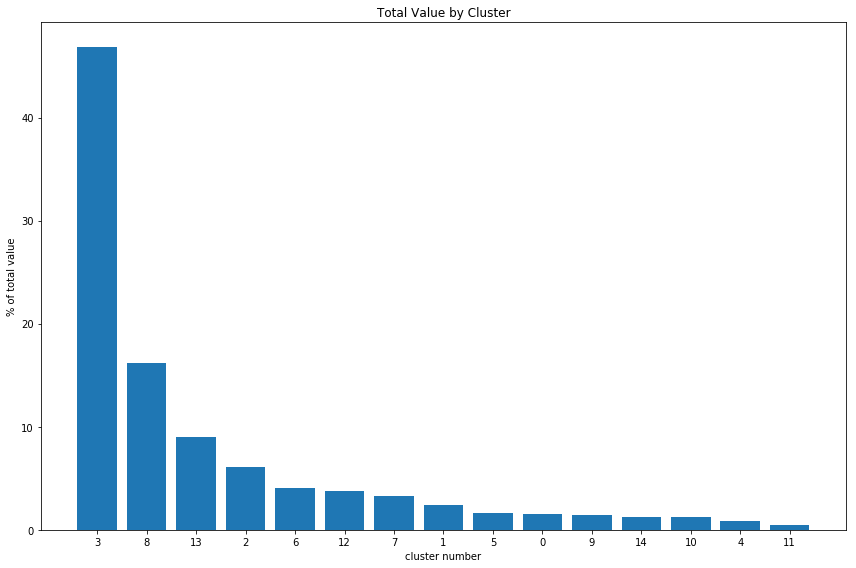

In [32]:

names = np.array(list(total_eth.keys()))
values = np.array(list(total_eth.values()))
indices = np.argsort(values)

names = names[indices][::-1]
values = values[indices][::-1]
                  
#tick_label does the some work as plt.xticks()
plt.figure(figsize=(12,8))
plt.bar(range(len(total_eth)),values/sum(values)*100,tick_label=names)
plt.title('Total Value by Cluster')
plt.xlabel('cluster number')
plt.ylabel('% of total value')
# plt.yscale('log')
plt.tight_layout()
plt.show()




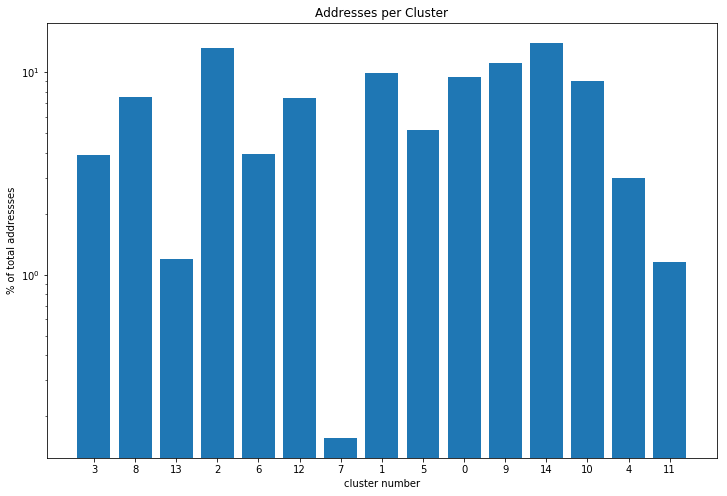

In [33]:

names = np.array(list(total_addresses.keys()))
values = np.array(list(total_addresses.values()))

names = names[indices][::-1]
values = values[indices][::-1]
                  
#tick_label does the some work as plt.xticks()
plt.figure(figsize=(12,8))
plt.bar(range(len(total_addresses)),values/sum(values)*100,tick_label=names)
plt.title('Addresses per Cluster')
plt.yscale('log')
plt.xlabel('cluster number')
plt.ylabel('% of total addressses')
plt.show()

In [34]:


# for clust in range(cl.n_clusters):
#     cluster_data = df[cl.labels_==clust]
#     print('cluster {}'.format(clust))
#     logbins = np.logspace(0,8,16)
#     plt.hist(cluster_data['incoming_avg_time_btwn_txns'], bins=logbins)
#     plt.xscale('log')
#     plt.show()
    

In [35]:
labelresults = pipe.fit_transform(dflabel.iloc[:,3:-1])

In [36]:
labelcl = KMeans(15).fit(labelresults)
dflabel['cluster'] = [labelcl.labels_[i] for i in range(len(dflabel))]

In [37]:
time_start = time.time()
tsne_label = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=20000)
tsne_results_label = tsne_label.fit_transform(labelresults)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 126 samples in 0.000s...
[t-SNE] Computed neighbors for 126 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 126 / 126
[t-SNE] Mean sigma: 2.179820
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.194481
[t-SNE] KL divergence after 1200 iterations: 0.298448
t-SNE done! Time elapsed: 0.487473726272583 seconds


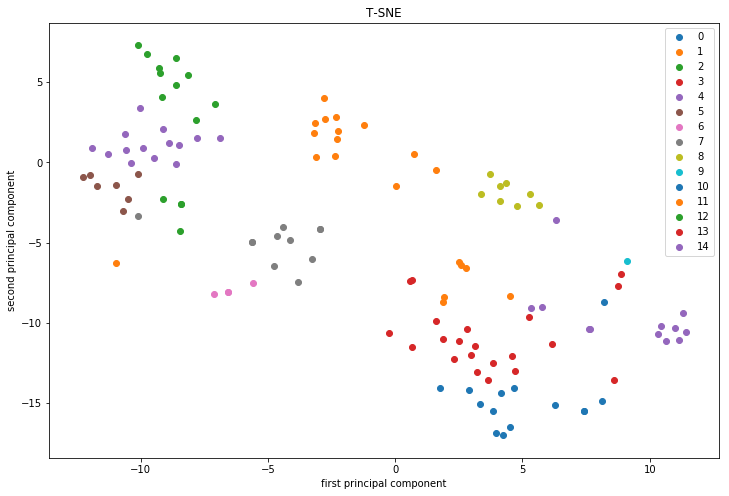

In [38]:
plt.figure(figsize=(12,8))
for c in np.unique(labelcl.labels_):
    mask = labelcl.labels_==c
    if np.sum(mask) <1:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results_label[mask][:,0], tsne_results_label[mask][:,1], alpha=1,label=lbl)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

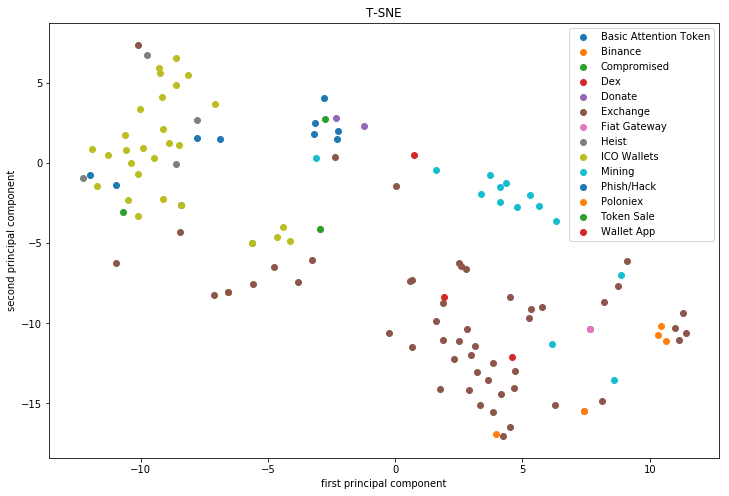

In [39]:
plt.figure(figsize=(12,8))

for c in np.unique(dflabel['category']):
    mask = dflabel['category']==c
    if np.sum(mask) <1:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results_label[mask][:,0], tsne_results_label[mask][:,1], alpha=1,label=lbl)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

## subset original T-SNE results
create a mask for all points that are labelled

In [40]:
labeled_addresses = dflabel['address'].values
labelmask = np.array([addr in labeled_addresses for addr in df['address'] ] )

#labelmask for subset results!!!
labelmask = np.array([addr in labeled_addresses for addr in df['address'][address_mask]] )

In [41]:
#helper function for category mask
def cat(addr, labeled_addresses, dflabel):
    if addr not in labeled_addresses:
        return False
    else:
        idx = int(np.where(labeled_addresses==addr)[0][0])
        return dflabel['category'][idx]

In [42]:
#setting up color map
NUM_COLORS = len(dflabel['category'].unique())
cm = plt.get_cmap('tab20')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  if sys.path[0] == '':


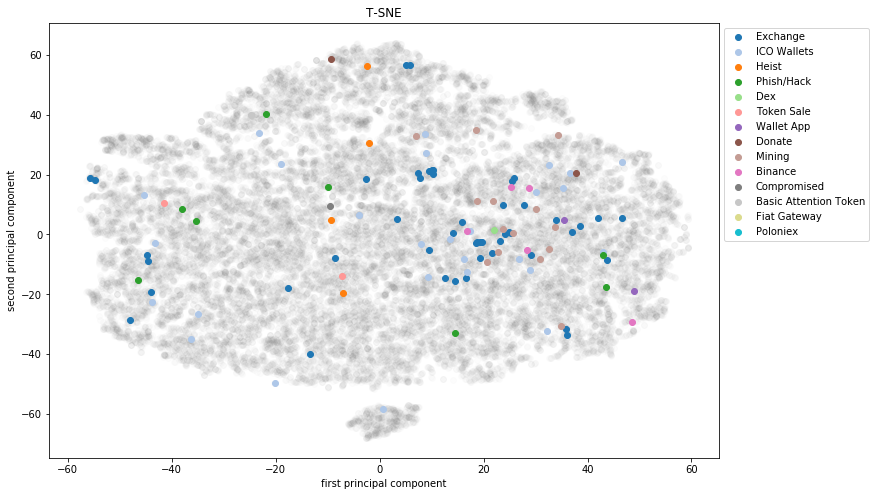

In [43]:
subset, not_subset  = tsne_results[labelmask] , tsne_results[~labelmask]
fig = plt.figure(figsize=(12,8))
#not labelled points
plt.scatter(not_subset[:,0], not_subset[:,1], c='gray', alpha=.02)

#categories
cats = np.array([cat(addr, labeled_addresses, dflabel) for addr in df['address'][address_mask] ]) #added address mask for all clusters

#labelled points

ax = fig.add_subplot(111)
ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for c in list(dflabel['category'].unique()):
    mask = dflabel['category']==c
    if np.sum(mask) <1:
        lbl = '_nolegend_'
    else:
        lbl = c
    
    #category mask
    catmask = cats == c

    plt.scatter(tsne_results[(labelmask & catmask)][:,0], tsne_results[(labelmask & catmask)][:,1], alpha=1,label=lbl)

leg = plt.legend(bbox_to_anchor=(1, 1))
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

In [45]:
for clust in range(cl.n_clusters):
    print('cluster {}'.format(clust))
    print('labelled points: {}'.format(np.sum([dflabel['cluster']==clust])))
    print('total points: {}'.format(np.sum(cl.labels_==clust)))
    print(dflabel[dflabel['cluster']==clust][['label', 'category']])
    print('\n\n\n')

cluster 0
labelled points: 5
total points: 3380
          label  category
115  ShapeShift  Exchange
116    Kraken_1  Exchange
117  Poloniex_1  Exchange
118  Poloniex_1  Poloniex
122   Bittrex_1  Exchange




cluster 1
labelled points: 9
total points: 3531
             label    category
0          Bgogo_1    Exchange
3         Bitmax_1    Exchange
20             Uex    Exchange
26      BitUN.io_2    Exchange
27            Cobo  Wallet App
38  WhalesburgPool      Mining
88         Huobi_7    Exchange
92         Huobi_9    Exchange
93         Huobi_3    Exchange




cluster 2
labelled points: 9
total points: 4731
                      label     category
16              INCX_Wallet  ICO Wallets
30              Hero_Wallet  ICO Wallets
72           Monetha_Wallet  ICO Wallets
81        Santiment_Wallet2  ICO Wallets
84   MultisigExploit-Hacker        Heist
95        Santiment_Wallet1  ICO Wallets
98       SingularDTV_Wallet  ICO Wallets
99                 Kraken_3     Exchange
119          